# LSAP Data Inspection & Preprocessing
---
This notebook contains code for the LSAP preprocessing step used in our NLP project. 


## Install Libraries & Set Seed

In [ ]:
%%capture
!pip install transformers
!pip install datasets

In [ ]:
import random, re, torch
import numpy as np
import pandas as pd

def set_seed( seed ):
    random.seed( seed )
    np.random.seed( seed )
    torch.manual_seed( seed )
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all( seed )

#Set seed for consistency
set_seed(42)

## Preprocess pre-training dataset

Our pre-training dataset is a combination of the [Banking77 Dataset](https://huggingface.co/datasets/PolyAI/banking77) and [WikiHow Intents Dataset](https://github.com/zharry29/wikihow-intent) with a few tweaks. Below, we load them both in, preprocess them, and get them ready for training our model.

---

### Load PolyBanking Dataset

In [ ]:
#Load PolyBanking Dataset from HuggingFace
from datasets import load_dataset, Dataset, concatenate_datasets, ClassLabel
banking_dataset = load_dataset("PolyAI/banking77")

#Return Dataframe to perform operations on
banking_dataset.set_format( type="pandas" )
banking_dataset

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})

### Inspection

Below, we inspect our dataset to look for imbalances in labels, and to see if we need to sample our data differently.

In [ ]:
#Obtain pandas dataframe
banking_df = banking_dataset["train"][:]

def add_labelname( row ):
  return banking_dataset["train"].features["label"].int2str( row )

#Add label name associated with each label
banking_df["label_name"] = banking_df["label"].apply( add_labelname )
banking_df.sample( frac = 1 ).head( 10 )

,text,label,label_name
6883,Is it possible for me to change my PIN number?,21,change_pin
5836,I'm not sure why my card didn't work,25,declined_card_payment
8601,I don't think my top up worked,59,top_up_failed
2545,Can you explain why my payment was charged a fee?,15,card_payment_fee_charged
8697,How long does a transfer from a UK account tak...,5,balance_not_updated_after_bank_transfer
5573,Why am I getting declines when trying to make ...,27,declined_transfer
576,What is the $1 transaction on my account?,34,extra_charge_on_statement
6832,It looks like my card payment was sent back.,53,reverted_card_payment?
7111,Why am I unable to transfer money when I was a...,7,beneficiary_not_allowed
439,What if there is an error on the exchange rate?,17,card_payment_wrong_exchange_rate


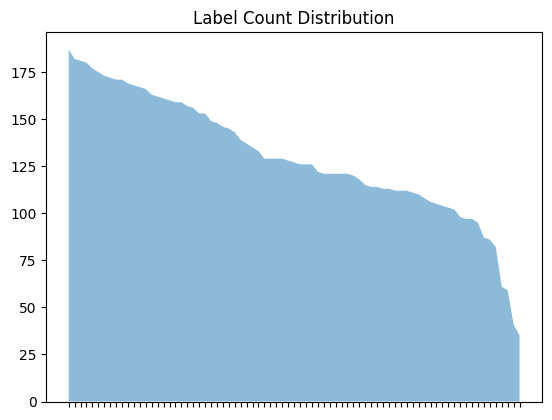

In [ ]:
import matplotlib.pyplot as plt

# Get frequency of each label
label_counts = banking_df["label_name"].value_counts()

# Sort the label counts in descending order
sorted_counts = label_counts.sort_values( ascending = False )

# Create a sorted list of labels and their corresponding counts
labels = sorted_counts.index.tolist()
counts = sorted_counts.tolist()

# Create an area graph
plt.stackplot(labels, counts, alpha=0.5)
plt.gca().set_xticklabels([])
plt.title("Label Count Distribution")

plt.show()

### Load WikiHow Intent Dataset

In [ ]:
!gdown 1KaFOVZFxZoR6weLuDNmVFwRRsGTFq5tJ

Downloading...
From: https://drive.google.com/uc?id=1KaFOVZFxZoR6weLuDNmVFwRRsGTFq5tJ
To: /content/en_wikihow_train.csv
100% 28.2M/28.2M [00:00<00:00, 184MB/s]


### Preprocess 

We want to keep both datasets in the same format to combine them later.

In [ ]:
import pandas as pd
import re

def create_label_name(df):
    """
    Create a column with each sentence's intent label.
    """
    df[ 'label_name' ] = df.apply( lambda row: row[ f'ending{row["label"]}' ], axis=1 )
    return df

def drop_ending_columns(df):
    """
    Drop the 'ending' columns from the dataframe.
    """
    endings_to_drop = [ f'ending{i}' for i in range( 4 ) ]
    df = df.drop( endings_to_drop, axis=1 )
    return df

def remove_how_to(df):
    """
    Remove "How to" from utterances.
    """
    pattern = re.compile( r'(?i)How to ' )
    df[ 'label_name' ] = df[ 'label_name' ].apply( lambda x: re.sub( pattern, '', x ).strip() )
    return df

# Load data
wikihow_df = pd.read_csv( '/content/en_wikihow_train.csv', index_col=0 )

# Drop unnecessary columns
wikihow_df = wikihow_df.drop(['startphrase', 'video-id', 'gold-source', 'fold-ind', 'sent1'], axis = 1)

# Append label name to each column
wikihow_df = create_label_name( wikihow_df )

# Drop the 'ending' columns
wikihow_df = drop_ending_columns( wikihow_df ).drop(['label'], axis=1 )

# Remove "How to" from the 'label_name' column (case-insensitive)
wikihow_df = remove_how_to( wikihow_df ).rename( columns={'sent2': 'text'} )

In [ ]:
wikihow_df.head( 10 )

,text,label_name
0,"If you have a hand only strong in one suit, re...",Shoot the Moon in Hearts
1,Dodge the guardian's attacks in editor mode by...,Get the Sandbox Skull in Halo 3
2,Mix resin and hardener according to package di...,Fiberglass a Boat
3,Wait until the fire has spread so the water in...,Fire a Steam Locomotive
4,Soak the awing in cleaning solution.,Remove Mildew from Canvas Awnings
5,Wear comfortable clothes.,Stay Sane on the Road Trip
6,"Target training your betta is another easy, fu...",Play With Your Betta Fish
7,Be aware that some apps come with Notification...,Personalize the Settings on Your iPad 2
8,Make physical contact with the person.,Express Sympathy
9,Install weather strip behind cab.,Install the American Roll Tonneau Cover


### Inspection

Below, we inspect our dataset to look for imbalances in labels, and to see if we need to sample our data differently. In the banking dataset, each label was associated with multiple entries. In our Wikihow Intents, however, each label is used only once.

In [ ]:
#Count if any two articles have the same intent
num_unique = wikihow_df['label_name'].nunique()
num_unique

110573

In [ ]:
#Convert to HuggingFace Dataset (gives better interopoerability w/ models)
wikihow_dataset = Dataset.from_pandas( wikihow_df , preserve_index =False )

#Generate train/test split
wikihow_dict    = wikihow_dataset.train_test_split( test_size=0.2, shuffle=True )

#Extract training dataframe
wikihow_dict.set_format( type="pandas" )
wikihow_train = wikihow_dict[ "train" ][ : ]

#Shuffle dataframe
wikihow_train.sample( frac = 1 ).head( 5 )

## Merge Training Datasets

In [ ]:
bank_labels  = banking_df.drop( ["label"], axis = 1 )
merged_train = pd.concat([ banking_df, wikihow_train ])

#Convert each WikiHow intent to a ClassLabel
labels = merged_train[ 'label_name' ].unique().tolist()
ClassLabels = ClassLabel( num_classes=len( labels ), names=labels )

#Append ClassLabels into DataFrame
def map_label2id( row ):
    return ClassLabels.str2int( row )

merged_train["label"] = merged_train[ "label_name" ].apply( map_label2id )
merged_train = merged_train.reset_index( drop = True )

#Display
merged_train.sample( frac = 1 ).head( 10 )

,text,label,label_name
2264,Can I top-up any amount I wish on any given day?,18,top_up_limits
5092,What does it mean when a payment is pending?,40,pending_card_payment
28579,Visit your doctor for a Zentel prescription to...,18653,Take Zentel
66891,Switch to source editing mode in your comment ...,56965,Type Emoji on the wikiHow Forums
72460,Approach the source of frustration carefully.,62534,Reduce Frustration in Your Life
91881,Directly access the media studio if you'd like.,81955,Access Twitter Media Studio
88023,Use the tip of a rattail comb to separate your...,78097,Part Your Hair
42088,Help them learn numeracy (creating links to ot...,32162,Teach a Young Child Beginning Math Skills
95919,Make sure you understand your assignments.,85993,Get Straight A's in College
22391,Avoid posting inflammatory comments or picture...,12465,Handle Haters and Jealous People


In [ ]:
merged_train.to_csv("/content/train.csv")